In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

import models
from config import Config
from evaluation import ModelEvaluator

# (If necessary) Load the k fold performances

In [81]:
import pickle

with open('latent_ocnn_fold_performances.pkl', 'rb') as file: # variational_autoencoder_fold_performances.pkl / denoising_autoencoder_fold_performances.pkl / autoencoder_fold_performances.pkl / ocnn_fold_performances.pkl
    metrics_list = pickle.load(file)

print(metrics_list)

[{'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'mcc': -0.05556094532666466, 'auc': 0.21369797997033627}, {'precision': 0.0024630541871921183, 'recall': 3.517163759144626e-05, 'f1_score': 6.935293709688605e-05, 'mcc': -0.08438312477671042, 'auc': 0.21389973196520348}, {'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'mcc': -0.056036641053859484, 'auc': 0.2126443449845601}, {'precision': 0.006993006993006993, 'recall': 0.00014068655036578504, 'f1_score': 0.00027582402427251415, 'mcc': -0.0993934464827609, 'auc': 0.21373961207069225}, {'precision': 0.009333333333333334, 'recall': 0.0002462014631401238, 'f1_score': 0.0004797477897333973, 'mcc': -0.11345184650995346, 'auc': 0.2137988312268881}, {'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'mcc': -0.06685129850693274, 'auc': 0.21366596526926473}, {'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'mcc': -0.055719956206157814, 'auc': 0.2127439344561392}, {'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'mcc': -0.084484733829617

# Compute k-fold average metrics
- one time with auc
- one time without auc

In [57]:
# Initialize accumulators
total_precision = 0
total_recall = 0
total_f1_score = 0
total_mcc = 0
total_auc = 0

# Iterate through each dictionary and add up the metric values
for metrics in metrics_list:
    total_precision += metrics["precision"]
    total_recall += metrics["recall"]
    total_f1_score += metrics["f1_score"]
    total_mcc += metrics["mcc"]
    total_auc += metrics["auc"]

# Calculate averages
average_precision = total_precision / len(metrics_list)
average_recall = total_recall / len(metrics_list)
average_f1_score = total_f1_score / len(metrics_list)
average_mcc = total_mcc / len(metrics_list)
average_auc = total_auc / len(metrics_list)

# Print or return the averages
averages = {
    "average_precision": average_precision,
    "average_recall": average_recall,
    "average_f1_score": average_f1_score,
    "average_mcc": average_mcc,
    "average_auc": average_auc
}

print(averages)

{'average_precision': 0.819412301138453, 'average_recall': 0.8322867374344545, 'average_f1_score': 0.8257920054521515, 'average_mcc': 0.7288839174876693, 'average_auc': 0.9200142659697678}


In [68]:
# Initialize accumulators
total_precision = 0
total_recall = 0
total_f1_score = 0
total_mcc = 0

# Iterate through each dictionary and add up the metric values
for metrics in metrics_list:
    total_precision += metrics["precision"]
    total_recall += metrics["recall"]
    total_f1_score += metrics["f1_score"]
    total_mcc += metrics["mcc"]

# Calculate averages
average_precision = total_precision / len(metrics_list)
average_recall = total_recall / len(metrics_list)
average_f1_score = total_f1_score / len(metrics_list)
average_mcc = total_mcc / len(metrics_list)

# Print or return the averages
averages = {
    "average_precision": average_precision,
    "average_recall": average_recall,
    "average_f1_score": average_f1_score,
    "average_mcc": average_mcc,
}

print(averages)

{'average_precision': 0.25660210167361935, 'average_recall': 0.23727490151941474, 'average_f1_score': 0.24655929128588167, 'average_mcc': -0.4514119147555958}


# Running Baselines models k times if they have random seeds

### normal dataset

In [61]:
from data_loader import MyDataLoader

loader = MyDataLoader()

# Load setups
setup = loader.load_setup('../../data/setup_1.pkl')

loader.fit_data(setup['X_train'])
X_train = loader.transform_data(setup['X_train'])
X_test = loader.transform_data(setup['X_test'])

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

y_test = setup['y_test']

print("Label Shape:", y_test.shape)

Training Data Shape: (255883, 29)
Testing Data Shape: (56864, 29)
Label Shape: (56864,)


### autoencoder encoded dataset

In [65]:
from data_loader import MyDataLoader

loader = MyDataLoader()

# Load setups
setup = loader.load_setup('../../data/setup_1_latent.pkl')

X_train = setup['X_train']
X_test = setup['X_test']

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

y_test = setup['y_test']

print("Label Shape:", y_test.shape)

Training Data Shape: (255883, 8)
Testing Data Shape: (56864, 8)
Label Shape: (56864,)


### import evaluation scheme and models

In [56]:
import models
from evaluation import ModelEvaluator

## naive baseline (no randomness)

In [9]:
model = models.NaiveBaseline()
y_pred = model.predict(X_test)

evaluator = ModelEvaluator(y_test, y_pred, y_pred)
evaluator.basic_report()

Basic Evaluation Metrics:
Precision: 0.5
Recall: 1.0
F1-Score: 0.6666666666666666
MCC: 0.0
AUC: 0.5


{'precision': 0.5,
 'recall': 1.0,
 'f1_score': 0.6666666666666666,
 'mcc': 0.0,
 'auc': 0.5}

## kmeans (randomness)

In [66]:
metrics_list = []
for random_seed in range(10):
    model = models.KMeansAnomalyDetector(n_clusters=2, n_init=10, random_state=random_seed)
    model.fit(X_test)
    y_pred = model.predict(X_test)
    
    evaluator = ModelEvaluator(y_test, y_pred)
    metrics_list.append(evaluator.basic_report())

Basic Evaluation Metrics:
Precision: 0.25669363108123505
Recall: 0.23772509848058526
F1-Score: 0.24684549787265125
MCC: -0.45188966696929866
Basic Evaluation Metrics:
Precision: 0.25692704774918396
Recall: 0.23807681485649973
F1-Score: 0.24714301361860602
MCC: -0.4516956839717428
Basic Evaluation Metrics:
Precision: 0.256796780072904
Recall: 0.23786578503095104
F1-Score: 0.24696903301197778
MCC: -0.4517779666925079
Basic Evaluation Metrics:
Precision: 0.25682499905076506
Recall: 0.2379009566685425
F1-Score: 0.2470010407347222
MCC: -0.45174152167835746
Basic Evaluation Metrics:
Precision: 0.2563468199292049
Recall: 0.23688097917839054
F1-Score: 0.24622977789964356
MCC: -0.4516063871161217
Basic Evaluation Metrics:
Precision: 0.2558909594948406
Recall: 0.23375070343275184
F1-Score: 0.24432027056834058
MCC: -0.44765510692526994
Basic Evaluation Metrics:
Precision: 0.25672185933464986
Recall: 0.23776027011817671
F1-Score: 0.24687751077350084
MCC: -0.45185321836286096
Basic Evaluation Metri

## ocsvm (no randomness)

In [80]:
model = models.OCSVM()
model.fit(X_train)
y_pred = model.predict(X_test)
y_pred = (y_pred == -1).astype(int)

# anomaly scores (e.g. for ROC or PR curve)
y_scores = model.anomaly_scores(X_test)

evaluator = ModelEvaluator(y_test, y_pred, -y_scores)
evaluator.basic_report()

Basic Evaluation Metrics:
Precision: 0.579232693911593
Recall: 0.683947664603264
F1-Score: 0.6272498548480743
MCC: 0.19024779606091166
AUC: 0.6166273070575404


{'precision': 0.579232693911593,
 'recall': 0.683947664603264,
 'f1_score': 0.6272498548480743,
 'mcc': 0.19024779606091166,
 'auc': 0.6166273070575404}

## sgd ocsvm (randomness)

In [72]:
metrics_list = []
for random_seed in range(10):
    model = models.SGDOCSVM(random_state=random_seed)
    model.fit(X_train)
    y_pred = model.predict(X_test)
    y_pred = (y_pred == -1).astype(int)
    
    # anomaly scores (e.g. for ROC or PR curve)
    y_scores = model.anomaly_scores(X_test)
    
    evaluator = ModelEvaluator(y_test, y_pred, -y_scores)
    metrics_list.append(evaluator.basic_report())

Basic Evaluation Metrics:
Precision: 0.07680101555061886
Recall: 0.01702307259425999
F1-Score: 0.027868946853227387
MCC: -0.29881451510236395
AUC: 0.20974178555221173
Basic Evaluation Metrics:
Precision: 0.07693517935808684
Recall: 0.01719893078221722
F1-Score: 0.028113142462918246
MCC: -0.30015720158699616
AUC: 0.20973935537909522
Basic Evaluation Metrics:
Precision: 0.07651924912503977
Recall: 0.01691755768148565
F1-Score: 0.027708969410680337
MCC: -0.2985864067392642
AUC: 0.20974409325796323
Basic Evaluation Metrics:
Precision: 0.07692307692307693
Recall: 0.01712858750703433
F1-Score: 0.02801829531398326
MCC: -0.2995007737407682
AUC: 0.20973984834116544
Basic Evaluation Metrics:
Precision: 0.07671580282136631
Recall: 0.01702307259425999
F1-Score: 0.02786333151031922
MCC: -0.29906132759549836
AUC: 0.20973533622284402
Basic Evaluation Metrics:
Precision: 0.07681410357311506
Recall: 0.017163759144625774
F1-Score: 0.02805807100761823
MCC: -0.30016332359334913
AUC: 0.20974071674611722
Ba

## knn distance (no randomness)

In [71]:
model = models.KNNAnomalyDetector(n_neighbors=5)
model.fit(X_train)
model.compute_threshold(X_train, percentile=95) #distances as anomaly score
y_pred, kth_distances = model.predict(X_test)
y_pred = (y_pred == True).astype(int)

evaluator = ModelEvaluator(y_test, y_pred, kth_distances)
evaluator.basic_report()

Basic Evaluation Metrics:
Precision: 0.866166405541354
Recall: 0.36944288126055147
F1-Score: 0.5179614882023719
MCC: 0.3812867842550902
AUC: 0.8273388102355363


{'precision': 0.866166405541354,
 'recall': 0.36944288126055147,
 'f1_score': 0.5179614882023719,
 'mcc': 0.3812867842550902,
 'auc': 0.8273388102355363}

## LOF (no randomness)

In [74]:
model = models.LOFAnomalyDetector(n_neighbors=5, contamination=0.5)
y_pred = model.fit_predict(X_test) # fit and predict not possible for novelty=False, have to use fit_predict
y_pred = (y_pred == -1).astype(int)

evaluator = ModelEvaluator(y_test, y_pred, -model.model.negative_outlier_factor_)
evaluator.basic_report()

Basic Evaluation Metrics:
Precision: 0.4225168823860439
Recall: 0.4225168823860439
F1-Score: 0.4225168823860439
MCC: -0.15496623522791222
AUC: 0.38585964761977676


{'precision': 0.4225168823860439,
 'recall': 0.4225168823860439,
 'f1_score': 0.4225168823860439,
 'mcc': -0.15496623522791222,
 'auc': 0.38585964761977676}

## Isolation Forest (randomness)

In [75]:
metrics_list = []
for random_seed in range(10):
    model = models.IsolationForestDetector(n_estimators=100, max_samples='auto', contamination='auto', random_state=random_seed)
    model.fit(X_train)
    y_pred = model.predict(X_test)
    y_pred = (y_pred == -1).astype(int)
    
    # anomaly scores (e.g. for ROC or PR curve)
    y_scores = model.anomaly_scores(X_test)
    
    evaluator = ModelEvaluator(y_test, y_pred, -y_scores)
    metrics_list.append(evaluator.basic_report())

Basic Evaluation Metrics:
Precision: 0.6695301728709301
Recall: 0.22203854811480023
F1-Score: 0.33348300361849925
MCC: 0.15116817358038961
AUC: 0.6272805415003155
Basic Evaluation Metrics:
Precision: 0.6120030007501875
Recall: 0.14346510973550927
F1-Score: 0.23244151921816678
MCC: 0.08162293328418369
AUC: 0.6056315450023577
Basic Evaluation Metrics:
Precision: 0.6570065176908753
Recall: 0.19854389420371413
F1-Score: 0.30493733794295597
MCC: 0.13247903767396105
AUC: 0.6416974195002959
Basic Evaluation Metrics:
Precision: 0.6408853519025118
Recall: 0.18127462014631401
F1-Score: 0.2826122717552229
MCC: 0.11435893124503842
AUC: 0.6232101431717225
Basic Evaluation Metrics:
Precision: 0.6684979230872303
Recall: 0.17547129994372537
F1-Score: 0.27797743418303383
MCC: 0.1309825371356371
AUC: 0.621285968714581
Basic Evaluation Metrics:
Precision: 0.6669985617878084
Recall: 0.21204980303882948
F1-Score: 0.3217955218702463
MCC: 0.14520294689945581
AUC: 0.62420629086303
Basic Evaluation Metrics:
Pr

## Mahalonobis distance (no randomness)

In [77]:
model = models.MahalanobisAnomalyDetector()
model.fit(X_train)
model.compute_threshold(X_train, percentile=95) #distances as anomaly score
y_pred, y_scores = model.predict(X_test)
y_pred = (y_pred == True).astype(int)

evaluator = ModelEvaluator(y_test, y_pred, y_scores)
evaluator.basic_report()

Basic Evaluation Metrics:
Precision: 0.6040342636087317
Recall: 0.07688519977490152
F1-Score: 0.1364076003868834
MCC: 0.05424519427886983
AUC: 0.6012423938117393


{'precision': 0.6040342636087317,
 'recall': 0.07688519977490152,
 'f1_score': 0.1364076003868834,
 'mcc': 0.05424519427886983,
 'auc': 0.6012423938117393}

## GMM (randomness)

In [78]:
metrics_list = []
for random_seed in range(10):
    model = models.GMMAnomalyDetector(n_components=3, random_state=random_seed)
    model.fit(X_train) 
    model.compute_threshold(X_train, std_multiplier=1)
    
    y_pred, y_scores = model.predict(X_test) 
    y_pred = (y_pred == True).astype(int)
    
    evaluator = ModelEvaluator(y_test, y_pred, -y_scores)
    metrics_list.append(evaluator.basic_report())

Basic Evaluation Metrics:
Precision: 0.623342175066313
Recall: 0.008265334833989871
F1-Score: 0.016314346211253432
MCC: 0.020152921738873782
AUC: 0.6928433971059581
Basic Evaluation Metrics:
Precision: 0.6780415430267063
Recall: 0.03214687675858188
F1-Score: 0.061383478844862324
MCC: 0.05548648424124656
AUC: 0.6583618903312317
Basic Evaluation Metrics:
Precision: 0.6780415430267063
Recall: 0.03214687675858188
F1-Score: 0.061383478844862324
MCC: 0.05548648424124656
AUC: 0.6583594273764467
Basic Evaluation Metrics:
Precision: 0.6780415430267063
Recall: 0.03214687675858188
F1-Score: 0.061383478844862324
MCC: 0.05548648424124656
AUC: 0.6583552993603157
Basic Evaluation Metrics:
Precision: 0.6780415430267063
Recall: 0.03214687675858188
F1-Score: 0.061383478844862324
MCC: 0.05548648424124656
AUC: 0.6583554243017687
Basic Evaluation Metrics:
Precision: 0.6780415430267063
Recall: 0.03214687675858188
F1-Score: 0.061383478844862324
MCC: 0.05548648424124656
AUC: 0.6583616602410308
Basic Evaluatio

## KDE (no randomness)

In [85]:
model = models.KDEAnomalyDetector(kernel='gaussian', bandwidth=0.5)
model.fit(X_train)  # X_train: Training data
model.compute_threshold(X_train, std_multiplier=1)

y_pred, y_scores = model.predict(X_test)

evaluator = ModelEvaluator(y_test, y_pred, -y_scores)
evaluator.basic_report()

Basic Evaluation Metrics:
Precision: 0.662109375
Recall: 0.2503868880135059
F1-Score: 0.3633625969783585
MCC: 0.1565581841013374
AUC: 0.6353614763569009


{'precision': 0.662109375,
 'recall': 0.2503868880135059,
 'f1_score': 0.3633625969783585,
 'mcc': 0.1565581841013374,
 'auc': 0.6353614763569009}

# Make "new" dataset through latent reprentation of the datasets with the best autoencoders encoder

In [19]:
from dl_models import CustomAE, Autoencoder
from config import Config
import torch
import torch.nn as nn
import numpy as np

In [20]:
# Set random seed
np.random.seed(Config.RANDOM_SEED)
torch.manual_seed(Config.RANDOM_SEED)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # device = "cpu"
print("Device used: ", device)

Device used:  cuda


In [22]:
# Convert training set to PyTorch tensor
X_train_tensor = torch.Tensor(X_train).to(device)

# Convert the test set to PyTorch tensor
X_test_tensor = torch.Tensor(X_test).to(device)

In [23]:
input_dim=X_train_tensor.shape[1]
input_dim

29

In [11]:
# best autoencoder had this structure:

# class CustomAE(nn.Module):
#     def __init__(self, input_dim):
#         super(CustomAE, self).__init__()
#         # Encoder
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, 16),
#             nn.BatchNorm1d(16),
#             nn.ELU(),
#             nn.Linear(16, 8),
#             nn.ELU()
#         )
#         # Decoder
#         self.decoder = nn.Sequential(
#             nn.Linear(8, 16),
#             nn.BatchNorm1d(16),
#             nn.ELU(),
#             nn.Linear(16, input_dim),
#             nn.ELU()
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

In [24]:
model = CustomAE(input_dim=input_dim)
model

CustomAE(
  (encoder): Sequential(
    (0): Linear(in_features=29, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ELU(alpha=1.0)
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Linear(in_features=16, out_features=29, bias=True)
    (4): ELU(alpha=1.0)
  )
)

In [25]:
model = model.to(device)

In [26]:
model.load_state_dict(torch.load('best_autoencoder_for_encoding_dataset.pth'))

<All keys matched successfully>

### test that the model is actually "good"

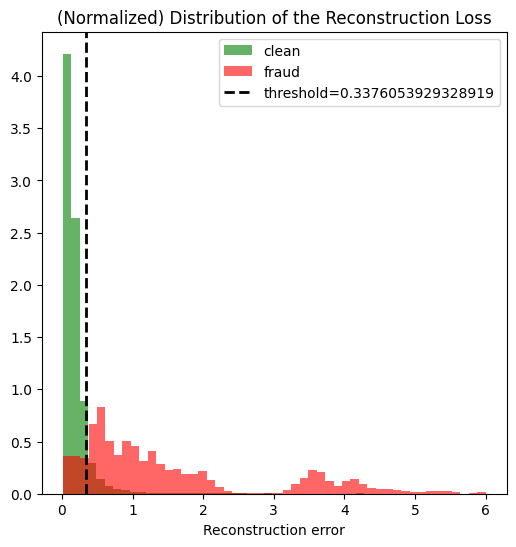

Number of outliers:  28164
Basic Evaluation Metrics:
Precision: 0.898096861241301
Recall: 0.8896314012380416
F1-Score: 0.8938440879214078
MCC: 0.7887238409705429
AUC: 0.9379925303418215


In [33]:
from evaluation import ModelEvaluator
import matplotlib.pyplot as plt

# Get the model's reconstruction of the test set
model.eval()
with torch.no_grad():
    reconstructions = model(X_train_tensor).cpu().numpy()

# Calculate the MSE reconstruction loss per row
train_mse = np.mean(np.power(X_train_tensor.cpu().numpy() - reconstructions, 2), axis=1)

threshold = np.quantile(train_mse, 0.90)

#### Evaluation
    
with torch.no_grad():
    reconstructions = model(X_test_tensor).cpu().numpy()

# Calculate the MSE reconstruction loss per row
mse = np.mean(np.power(X_test_tensor.cpu().numpy() - reconstructions, 2), axis=1)

clean = mse[y_test == 0]
fraud = mse[y_test == 1]

# Plotting the distribution of reconstruction loss
fig, ax = plt.subplots(figsize=(6,6))
ax.hist(clean[clean <= Config.PLOT_CLIPPING_VALUE], bins=50, density=True, label="clean", alpha=.6, color="green")
ax.hist(fraud[fraud <= Config.PLOT_CLIPPING_VALUE], bins=50, density=True, label="fraud", alpha=.6, color="red")
ax.axvline(threshold, color='black', linestyle='dashed', linewidth=2, label=f'threshold={threshold}')
plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.xlabel("Reconstruction error")
plt.legend()
plt.savefig("best_autoencoder_reconstruction_loss_test_dataset_with_threshold.png")
plt.show()

outliers = mse > threshold
print("Number of outliers: ", sum(outliers))

# Convert predictions to match y_test labels (1 for anomalies, 0 for normal)
y_pred = outliers.astype(int)

# compute metrics
evaluator = ModelEvaluator(y_test, y_pred, mse)
metrics = evaluator.basic_report()

## encoding the dataset to the latent space

In [35]:
model.eval()
# Transform the data using only the encoder part
with torch.no_grad():
    encoded_X_train = model.encoder(X_train_tensor).cpu().numpy()
    encoded_X_test = model.encoder(X_test_tensor).cpu().numpy()

In [52]:
encoded_X_train

array([[3.2018504 , 2.106742  , 1.7771053 , ..., 2.6001818 , 1.5712452 ,
        0.2648418 ],
       [1.8962164 , 1.8534446 , 1.859011  , ..., 3.3660688 , 0.5571087 ,
        0.5975636 ],
       [1.7979131 , 1.2056639 , 2.1025486 , ..., 3.6047344 , 0.45853156,
        1.3557084 ],
       ...,
       [1.4238945 , 2.2603192 , 1.8663855 , ..., 3.4379077 , 0.88286763,
        1.0849566 ],
       [1.7356632 , 1.7142673 , 1.232574  , ..., 3.5561767 , 0.82608485,
        0.9213147 ],
       [1.272428  , 1.3619392 , 0.43058717, ..., 3.4039807 , 0.90568894,
        0.97961265]], dtype=float32)

In [40]:
X_train_tensor.shape

torch.Size([255883, 29])

In [39]:
encoded_X_train.shape

(255883, 8)

In [41]:
X_test_tensor.shape

torch.Size([56864, 29])

In [42]:
encoded_X_test.shape

(56864, 8)

In [47]:
import pickle

# Prepare the new setup dictionary
new_setup = {
    'X_train': encoded_X_train,
    'X_test': encoded_X_test,
    'y_test': y_test  # Assuming you want to keep the labels the same
}

# Save the new setup to a pickle file
with open('../../data/setup_1_latent.pkl', 'wb') as file:
    pickle.dump(new_setup, file)

# Load models and apply them on a test set

In [22]:
metrics_list = []

In [34]:
from data_loader import MyDataLoader

loader = MyDataLoader()

# Load setups
setup1 = loader.load_setup('../../data/setup_1.pkl')
setup2 = loader.load_setup('../../data/setup_2.pkl')

loader.fit_data(setup1['X_train'])
X_train = loader.transform_data(setup1['X_train'])
X_test = loader.transform_data(setup2['X_test'])

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

y_test = setup2['y_test']
print("Testing Labels Data Shape:", y_test.shape)

Training Data Shape: (255883, 29)
Testing Data Shape: (44070, 29)
Testing Labels Data Shape: (44070,)


In [35]:
X_train_tensor = torch.Tensor(X_train)
X_test_tensor = torch.Tensor(X_test)

### Autoencoder

In [46]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ELU(),
            nn.Linear(16, 8),
            nn.ELU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ELU(),
            nn.Linear(16, input_dim),
            nn.ELU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [44]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.BatchNorm1d(16),
            nn.ELU(),
            nn.Linear(16, 8),
            nn.BatchNorm1d(8),
            nn.ELU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.BatchNorm1d(16),
            nn.ELU(),
            nn.Linear(16, input_dim),
            nn.ELU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [51]:
class Autoencoder(nn.Module): #VAE
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.BatchNorm1d(16),  # Batch normalization layer
            nn.ELU()
        )
        
        self.mean_layer = nn.Linear(16, 8)  # Mean of the latent space
        self.logvar_layer = nn.Linear(16, 8)  # Standard deviation of the latent space

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.BatchNorm1d(16),  # Batch normalization layer
            nn.ELU(),
            nn.Linear(16, input_dim),
            nn.ELU()  # or nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

In [55]:
input_dim = X_train.shape[1]
MODEL_TYPE = 'VAE'

In [56]:
metrics_list = []
for i in range(1,11):
    model = Autoencoder(input_dim)
    #autoencoder.load_state_dict(torch.load('autoencoder_best_parameters_f190.pth'))
    model.load_state_dict(torch.load('../../../10fold_performances/variationalAE/VariationalAutoencoder_fold{}.pth'.format(i)))
                          
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # GET THRESHOLD
    X_train_tensor = X_train_tensor.to(device)
    
    # Get the model's reconstruction of the test set
    model.eval()
    with torch.no_grad():
        if MODEL_TYPE == 'VAE':
            reconstructions, _, _ = model(X_train_tensor)
            reconstructions = reconstructions.cpu().numpy()
        else:
            reconstructions = model(X_train_tensor).cpu().numpy()
    
    # Calculate the MSE reconstruction loss per row
    train_mse = np.mean(np.power(X_train_tensor.cpu().numpy() - reconstructions, 2), axis=1)
    
    threshold = np.quantile(train_mse, 0.90)
    print(threshold)
    
    # EVALUATION
    
    # Convert the transformed test set to a PyTorch tensor
    X_test_tensor = X_test_tensor.to(device)
    
    # Get the model's reconstruction of the test set
    model.eval()
    with torch.no_grad():
        if MODEL_TYPE == 'VAE':
            reconstructions, _, _ = model(X_test_tensor)
            reconstructions = reconstructions.cpu().numpy()
        else:
            reconstructions = model(X_test_tensor).cpu().numpy()
    
    # Calculate the MSE reconstruction loss per row
    mse = np.mean(np.power(X_test_tensor.cpu().numpy() - reconstructions, 2), axis=1)
    
    outliers = mse > threshold
    print("Number of outliers: ", sum(outliers))
    
    # Convert predictions to match y_test labels (1 for anomalies, 0 for normal)
    y_pred = outliers.astype(int)
    
    # compute metrics
    evaluator = ModelEvaluator(y_test, y_pred, mse)
    metrics = evaluator.basic_report()
    
    metrics_list.append(metrics)

0.5435250759124757
Number of outliers:  15837
Basic Evaluation Metrics:
Precision: 0.8162530782345141
Recall: 0.8266402353242103
F1-Score: 0.8214138204924544
MCC: 0.7222578786154524
AUC: 0.9183096129973717
0.5354907035827637
Number of outliers:  15872
Basic Evaluation Metrics:
Precision: 0.8209425403225806
Recall: 0.8332267553395575
F1-Score: 0.827039035226912
MCC: 0.7308573706707289
AUC: 0.9206984504705252
0.5357627987861634
Number of outliers:  15878
Basic Evaluation Metrics:
Precision: 0.8169794684469077
Recall: 0.8295178411561581
F1-Score: 0.8232009138215509
MCC: 0.7248572155054859
AUC: 0.9184653978469542
0.5360929369926454
Number of outliers:  15774
Basic Evaluation Metrics:
Precision: 0.8175478635729682
Recall: 0.8246578846399796
F1-Score: 0.8210874824907678
MCC: 0.722037461791376
AUC: 0.9189386248311635
0.5296502590179444
Number of outliers:  16113
Basic Evaluation Metrics:
Precision: 0.821200273071433
Recall: 0.84614400818519
F1-Score: 0.8334855595099367
MCC: 0.7399612162462603

### OCNN 
not possible because we did not save the threshold r with the OCNN models and r is an optimized parameter during training

In [ ]:
class OneClassNN(nn.Module):
    def __init__(self, input_dim, hidden_layer_size, activation_func=nn.Sigmoid):
        """
        Initialize the One Class Neural Network.
        :param input_dim: The number of input features.
        :param hidden_layer_size: The number of neurons in the hidden layer.
        :param activation_func: The activation function to use in the hidden layer.
        """
        super(OneClassNN, self).__init__()
        self.dense_out1 = nn.Linear(input_dim, hidden_layer_size)
        self.out2 = nn.Linear(hidden_layer_size, 1)
        self.activation_func = activation_func()

    def forward(self, x):
        """
        Forward pass of the network.
        :param x: Input tensor.
        :return: Output tensor after passing through the network.
        """
        x = self.activation_func(self.dense_out1(x))
        return self.out2(x)

# Visualization of OCNN anomaly scores after epochs

In [2]:
VALIDATE_SIZE = 0.1
RANDOM_SEED = 0
batch_size = 256 # 

In [3]:
from data_loader import MyDataLoader

loader = MyDataLoader()

# Load setups
setup = loader.load_setup('../../data/setup_1.pkl')

loader.fit_data(setup['X_train'])
X_train = loader.transform_data(setup['X_train'])
X_test = loader.transform_data(setup['X_test'])

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

y_test = setup['y_test']
print("Testing Labels Data Shape:", y_test.shape)

Training Data Shape: (255883, 29)
Testing Data Shape: (56864, 29)
Testing Labels Data Shape: (56864,)


In [4]:
from sklearn.model_selection import train_test_split

# train // validate - no labels since they're all clean anyway
X_train_, X_validate_ = train_test_split(X_train, #X_train_scaled
                                       test_size=VALIDATE_SIZE, 
                                       random_state=RANDOM_SEED)

In [5]:
from torch.utils.data import DataLoader, TensorDataset

# Convert data to PyTorch tensors
X_train_tensor = torch.Tensor(X_train_)

# Create a dataset and data loader
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Convert validation data to PyTorch tensors
X_val_tensor = torch.Tensor(X_validate_)

# Create a dataset and data loader for validation
val_dataset = TensorDataset(X_val_tensor, X_val_tensor)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size)

# Convert test data to PyTorch tensor
X_test_tensor = torch.Tensor(X_test)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

class OneClassNN(nn.Module):
    def __init__(self, input_dim, hidden_layer_size, activation_func=nn.Sigmoid):
        """
        Initialize the One Class Neural Network.
        :param input_dim: The number of input features.
        :param hidden_layer_size: The number of neurons in the hidden layer.
        :param activation_func: The activation function to use in the hidden layer.
        """
        super(OneClassNN, self).__init__()
        self.dense_out1 = nn.Linear(input_dim, hidden_layer_size)
        self.out2 = nn.Linear(hidden_layer_size, 1)
        self.activation_func = activation_func()

    def forward(self, x):
        """
        Forward pass of the network.
        :param x: Input tensor.
        :return: Output tensor after passing through the network.
        """
        x = self.activation_func(self.dense_out1(x))
        return self.out2(x)

    
def quantile_loss(r, y_hat, nu):
    """
    3rd term in Eq (4) of the original paper
    :param r: bias of hyperplane
    :param y_hat: data / output we're operating on
    :param nu: parameter between [0, 1] controls trade-off between maximizing the distance of the hyperplane from
        the origin and the number of data points permitted to cross the hyper-plane (false positives) (default 1e-2)
    :return: the loss function value
    """
    return (1 / nu) * torch.mean(torch.relu(r - y_hat)) - r


def custom_ocnn_loss(model, r, nu):
    """
    Compute the OC-NN loss.
    :param y_hat: The predicted values from the model.
    :return: The computed loss value.
    """
    def loss(y_hat):
        w1_norm = 0.5 * torch.norm(model.dense_out1.weight)**2
        w2_norm = 0.5 * torch.norm(model.out2.weight)**2
        q_loss = quantile_loss(r, y_hat, nu)
        return w1_norm + w2_norm + q_loss
    return loss

In [7]:
input_dim = X_train.shape[1] 
hidden_layer_size = 12
init_lr = 1e-4 # 1e-2 for SGD, 1e-4 for Adam
epochs = 6
r = 1.0

In [8]:
nu = 0.01

In [18]:
# Model and Optimizer
model = OneClassNN(input_dim, hidden_layer_size)
optimizer = optim.Adam(model.parameters(), lr=init_lr)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [20]:
# Training Loop
mean_scores = []
variance_scores = []
for epoch in range(epochs):
    model.train()
    for data in train_loader:  # Assuming train_loader yields batches of data
        inputs, _ = data
        inputs = inputs.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = custom_ocnn_loss(model, r, nu)(outputs)
        loss.backward()
        optimizer.step()

        # Update r based on quantile of outputs
        with torch.no_grad():
            r = torch.quantile(outputs, nu).item()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

    model.eval()
    normal_count = 0
    total_count = 0

    with torch.no_grad():
        ### Training scores
        train_outputs = model(torch.Tensor(X_train).to(device))
        train_scores = train_outputs.cpu().numpy()
        train_scores = np.reshape(train_scores, -1)
        
        # Create histogram
        plt.figure(figsize=(10, 6))
        plt.hist(train_scores, bins=20, range=[0,3], alpha=0.7, label='Normal', color='green', density=True)
        plt.axvline(r, color='black', linestyle='dashed', linewidth=2, label=f'r={r}')
        plt.xlabel('Decision Scores')
        #plt.ylabel('Frequency')
        plt.xlim(0, 3)
        plt.ylim(0,7) # plt.ylim(0, 260000)
        plt.title('Training: Normalized Histogram of Decision Scores')
        plt.legend()
        plt.savefig("../../../visualization_ocnn/Histogram_decision_scores_Epoch{}.png".format(epoch))
        plt.close()

        # 1D plot
        plt.figure()
        plt.scatter(train_scores, [0]*len(train_scores), marker='|', s=50)
        plt.xlabel('Anomaly Scores')
        plt.xlim(0, 3)
        plt.title('Training: 1D Plot of Decision Scores')
        plt.yticks([])  # Hide the y-axis
        plt.savefig("../../../visualization_ocnn/1D_decision_scores_Epoch{}.png".format(epoch))
        plt.close()

        # store mean and variance over time
        mean_scores.append(np.mean(train_scores))
        variance_scores.append(np.var(train_scores))

        ### Testing scores
        test_outputs = model(torch.Tensor(X_test).to(device))
        test_scores = test_outputs.cpu().numpy()
        test_scores = np.reshape(test_scores, -1)

        # Create histogram
        # Assuming y_test contains the true labels (0 for normal, 1 for anomaly)
        normal_scores = test_scores[y_test == 0]
        anomaly_scores = test_scores[y_test == 1]
        
        # Create histogram
        plt.figure(figsize=(10, 6))
        plt.hist(normal_scores, bins=150, range=[0,3], alpha=0.7, label='Normal', color='green', density=True)
        plt.hist(anomaly_scores, bins=150, range=[0,3], alpha=0.7, label='Anomaly', color='red', density=True)
        plt.axvline(r, color='black', linestyle='dashed', linewidth=2, label=f'r={r}')
        plt.xlabel('Decision Scores')
        #plt.ylabel('Frequency')
        plt.xlim(0, 3)
        plt.ylim(0, 15)# plt.ylim(0, 10000)
        plt.title('Testing: Normalized Histogram of Decision Scores')
        plt.legend()
        plt.savefig("../../../visualization_ocnn/Histogram_decision_scores_testing_Epoch{}.png".format(epoch))
        plt.close()

Epoch 1/6, Loss: 0.2949551045894623
Epoch 2/6, Loss: -0.470074862241745
Epoch 3/6, Loss: -0.8405627012252808
Epoch 4/6, Loss: -1.1987214088439941
Epoch 5/6, Loss: -1.575148344039917
Epoch 6/6, Loss: -1.958207130432129


### train scores

In [16]:
# Evaluation on test data
model.eval()
with torch.no_grad():
    train_outputs = model(torch.Tensor(X_train).to(device))
    train_scores = train_outputs.cpu().numpy()
train_scores

array([[0.53919077],
       [0.5609317 ],
       [0.493335  ],
       ...,
       [0.513694  ],
       [0.5320164 ],
       [0.5883739 ]], dtype=float32)

In [17]:
train_scores = np.reshape(train_scores, -1)

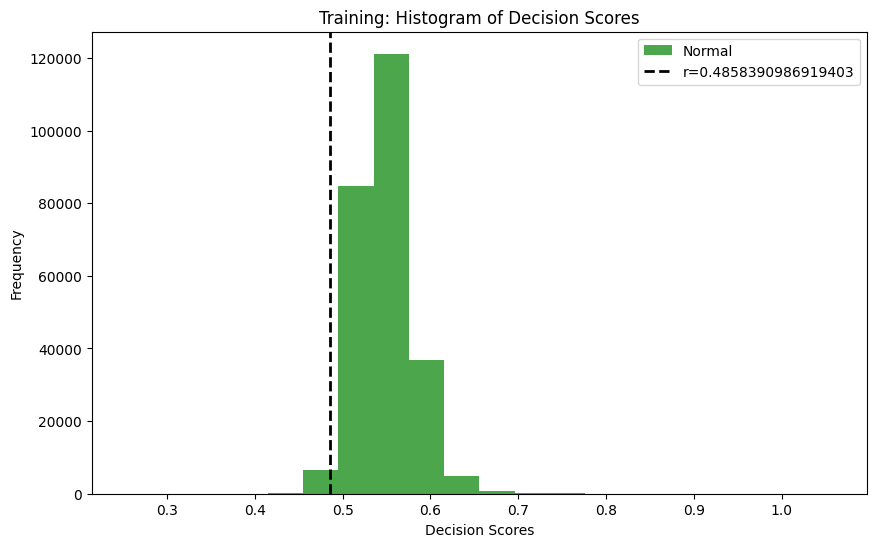

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(train_scores, bins=20, alpha=0.7, label='Normal', color='green')
plt.axvline(r, color='black', linestyle='dashed', linewidth=2, label=f'r={r}')
plt.xlabel('Decision Scores')
plt.ylabel('Frequency')
plt.title('Training: Histogram of Decision Scores')
plt.legend()
plt.savefig("Histogram_decision_scores.png")
plt.show()

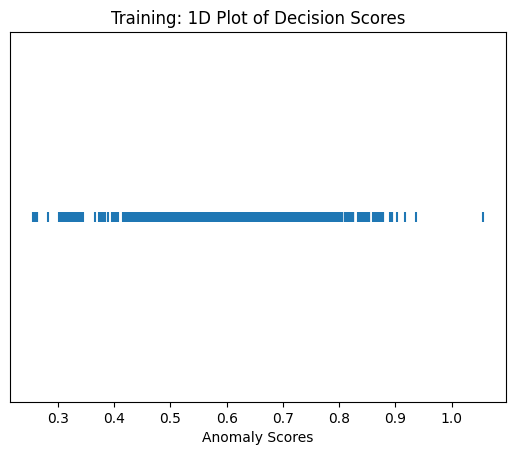

In [33]:
plt.scatter(train_scores, [0]*len(train_scores), marker='|', s=50)
plt.xlabel('Anomaly Scores')
plt.title('Training: 1D Plot of Decision Scores')
plt.yticks([])  # Hide the y-axis
plt.show()

### test scores

In [22]:
# Evaluation on test data
model.eval()
with torch.no_grad():
    test_outputs = model(torch.Tensor(X_test).to(device))
    test_scores = test_outputs.cpu().numpy()
test_scores

array([[0.5921033 ],
       [0.5455104 ],
       [0.5459193 ],
       ...,
       [0.44672242],
       [0.44756272],
       [0.31381106]], dtype=float32)

In [23]:
test_scores = np.reshape(test_scores, -1)

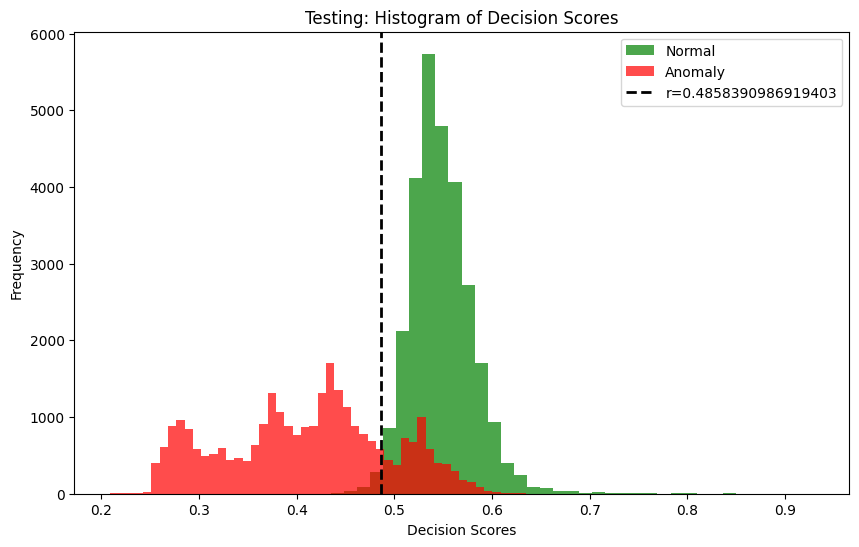

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test contains the true labels (0 for normal, 1 for anomaly)
normal_scores = test_scores[y_test == 0]
anomaly_scores = test_scores[y_test == 1]

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(normal_scores, bins=50, alpha=0.7, label='Normal', color='green')
plt.hist(anomaly_scores, bins=50, alpha=0.7, label='Anomaly', color='red')
plt.axvline(r, color='black', linestyle='dashed', linewidth=2, label=f'r={r}')
plt.xlabel('Decision Scores')
plt.ylabel('Frequency')
plt.title('Testing: Histogram of Decision Scores')
plt.legend()
plt.savefig("Histogram_decision_scores_testing.png")
plt.show()

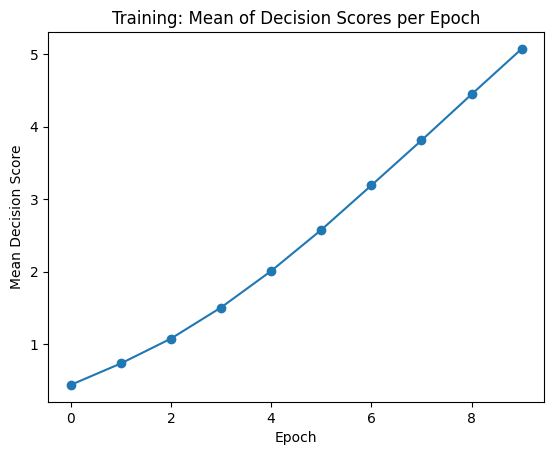

In [74]:
plt.plot(mean_scores, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Mean Decision Score')
plt.title('Training: Mean of Decision Scores per Epoch')
plt.savefig("../../../visualization_ocnn/Mean_Decision_Score.png")

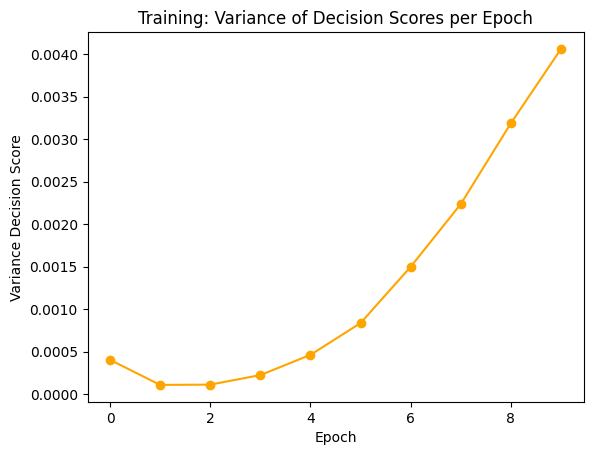

In [76]:
plt.plot(variance_scores, marker='o', c='orange')
plt.xlabel('Epoch')
plt.ylabel('Variance Decision Score')
plt.title('Training: Variance of Decision Scores per Epoch')
plt.savefig("../../../visualization_ocnn/Variance_Decision_Score.png")